In [95]:
import numpy as np
import pandas as pd
import glob
import os
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score
import tensorflow as tf
import autokeras as ak
print(sklearn.__version__)

1.0.2


In [96]:
files = os.path.join("/Users/carterblair/EEG-Analysis/train_files", "*.csv")
files = glob.glob(files)

df = pd.DataFrame()

for fl in files:
    temp_df = pd.read_csv(fl)
    temp_df = temp_df - temp_df.mean()
    df = pd.concat([df, temp_df], ignore_index=True)
df.columns=["x","y","ch1","ch2","ch3","ch4","ch5"]
df

,x,y,ch1,ch2,ch3,ch4,ch5
0,736.371158,-57.176591,-294.453871,20.475154,13.347498,161.519995,-15.115560
1,740.371158,-57.176591,-210.957777,3.873592,-0.324377,75.582495,-80.545247
2,740.371158,-57.176591,167.460192,-9.310002,-12.531409,145.406714,-50.760091
3,740.371158,-57.176591,162.577379,-9.310002,-13.996252,226.949683,4.415690
4,740.371158,-57.176591,-213.887465,-12.727971,-11.554846,176.656714,-5.349935
...,...,...,...,...,...,...,...
153974,-482.396034,-150.688553,-27.197122,-7.419651,19.427400,0.325911,23.524150
153975,-482.396034,-150.688553,6.494284,-9.861057,17.962557,4.720442,41.102275
153976,-482.396034,-150.688553,32.373191,-4.001682,7.220369,36.947004,66.981181
153977,-482.396034,-150.688553,14.306784,4.299099,4.778963,41.341536,73.328838


In [97]:
# Find direction cursor moved
targets = df[['x','y']].copy()
targets = targets.diff()
targets['x'][0] = 0
targets['y'][0] = 0
targets

,x,y
0,0.0,0.0
1,4.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0
...,...,...
153974,0.0,0.0
153975,0.0,0.0
153976,0.0,0.0
153977,0.0,0.0


In [98]:
new_targ = targets[['x','y']].copy()
i = new_targ[((new_targ.x == 0) & (new_targ.y == 0))].index  #find all rows with no cursor movement
new_targ = new_targ.drop(i) #drop all rows with no cursor movement

# zero out least significant component
new_targ.loc[(abs(new_targ['x'])>abs(new_targ['y'])), 'y'] = 0 
new_targ.loc[(abs(new_targ['x'])<abs(new_targ['y'])), 'x'] = 0

# set significant component to 1 or -1 based on its sign
new_targ.loc[new_targ['x']<0, 'x'] = -1
new_targ.loc[new_targ['x']>0, 'x'] = 1
new_targ.loc[new_targ['y']<0, 'y'] = -1
new_targ.loc[new_targ['y']>0, 'y'] = 1


y_df = new_targ[['y']].copy()

# make 4 classes:
#   1 = left
#   2 = right
#   3 = down
#   4 = up
y_df.loc[(new_targ['x']<0), 'y']=1
y_df.loc[(new_targ['x']>0), 'y']=2
y_df.loc[(new_targ['y']<0), 'y']=3
y_df.loc[(new_targ['y']>0), 'y']=4

y = y_df.to_numpy()
print(len(y))


17750


In [99]:
# Create feature vector and drop rows that had no cursor movement
inputs = df[['ch1','ch2','ch3','ch4','ch5']].copy()
inputs = inputs.drop(i)
#inputs = inputs-inputs.mean()
X = inputs.to_numpy()
print(len(X))
inputs

17750


,ch1,ch2,ch3,ch4,ch5
1,-210.957777,3.873592,-0.324377,75.582495,-80.545247
12,104.471910,-7.845158,-7.648596,205.465308,24.435221
24,348.612535,-0.032658,-3.742346,199.117652,60.079753
33,247.538317,-4.427189,1.628748,252.828589,20.528971
36,215.311754,24.381404,5.046716,129.781714,-31.228841
...,...,...,...,...,...
153942,2.099753,-7.419651,-13.775725,6.185286,3.016338
153954,1.611472,-6.931369,-4.010100,2.279036,-28.721944
153966,4.052878,11.135037,12.591463,2.767317,-27.745381
153971,27.002097,-3.513401,18.450838,20.833723,-30.675069


In [100]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [101]:
print(type(X_train))
print(X_train.shape)

<class 'numpy.ndarray'>
(11892, 5)


In [102]:
print(y_train.shape)
y_train = y_train.ravel()
print(y_train.shape)

(11892, 1)
(11892,)


In [110]:
clf_30_12 = MLPClassifier(solver='lbfgs', alpha=1e-4, hidden_layer_sizes=(50,), random_state=10, max_iter=60000)
clf_30_12.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(50,), max_iter=60000, random_state=10,
              solver='lbfgs')

In [111]:
y_hat = clf_30_12.predict(X_test)
y_hat_train = clf_30_12.predict(X_train)
print(f"(clf_30_12) balanced accuracy on train: {balanced_accuracy_score(y_train, y_hat_train)}")
print(f"(clf_30_12) balanced accuracy on test: {balanced_accuracy_score(y_test, y_hat)}")
print()
print(f"y_hat 1, {(y_hat == 1).sum()}")
print(f"y_test 1, {(y_test == 1).sum()}")


(clf_30_12) balanced accuracy on train: 0.3526847551541016
(clf_30_12) balanced accuracy on test: 0.30710047502394455

y_hat 1, 2286
y_test 1, 1586


/Users/carterblair/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


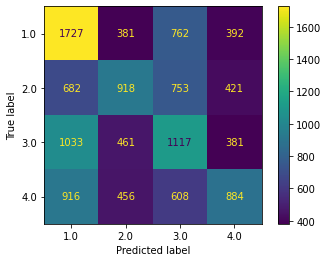

In [107]:
plot_confusion_matrix(clf_30_12, X_train, y_train)
plt.show()

/Users/carterblair/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


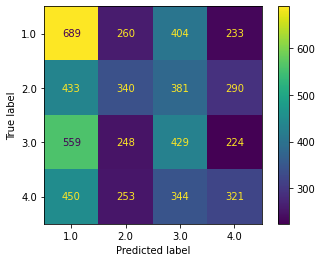

In [108]:
plot_confusion_matrix(clf_30_12, X_test, y_test)
plt.show()

In [109]:
print(f"y_train 1, {(y_train == 1).sum()}")
print(f"y_train 2, {(y_train == 2).sum()}")
print(f"y_train 3, {(y_train == 3).sum()}")
print(f"y_train 4, {(y_train == 4).sum()}")

y_train 1, 3262
y_train 2, 2774
y_train 3, 2992
y_train 4, 2864


In [40]:
#y = y.ravel()
#scores = cross_val_score(clf_30_12, X, y, cv=3)
#print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

### Now using AutoKeras

In [141]:
clf = ak.StructuredDataClassifier(max_trials=100)
# Feed the structured data classifier with training data.
y_train = y_train.reshape(-1,1)
y_train = y_train.astype(int)

#clf.fit(X_train, y_train, epochs=10)
clf.fit(X_train, y_train)

Trial 47 Complete [00h 03m 02s]
val_accuracy: 0.32258063554763794

Best val_accuracy So Far: 0.36035653948783875
Total elapsed time: 00h 32m 16s

Search: Running Trial #48

Value             |Best Value So Far |Hyperparameter
True              |True              |structured_data_block_1/normalize
False             |False             |structured_data_block_1/dense_block_1/use_batchnorm
3                 |3                 |structured_data_block_1/dense_block_1/num_layers
32                |32                |structured_data_block_1/dense_block_1/units_0
0                 |0                 |structured_data_block_1/dense_block_1/dropout
64                |64                |structured_data_block_1/dense_block_1/units_1
0                 |0.5               |classification_head_1/dropout
adam              |adam              |optimizer
0.001             |0.001             |learning_rate
32                |32                |structured_data_block_1/dense_block_1/units_2

Epoch 1/1000
298/298

In [139]:
predicted_y = clf.predict(X_test)
predicted_y_train = clf.predict(X_train)

372/372 [==============================] - 0s 1ms/step


In [140]:
predicted_y = predicted_y.astype(int)
y_test = y_test.astype(int)
predicted_y_train = predicted_y_train.astype(int)
y_train = y_train.astype(int)

print(f"(AutoKeras) balanced accuracy on train: {balanced_accuracy_score(y_train, predicted_y_train)}")
print(f"(AutoKeras) balanced accuracy on test: {balanced_accuracy_score(y_test, predicted_y)}")

(AutoKeras) balanced accuracy on train: 0.3386576035271175
(AutoKeras) balanced accuracy on test: 0.3130492024140553
